## Time Series Forecasting using Recurrent Neural Networks (RNN) in TensorFlow

In [1]:
#!pip install graphviz
#!pip install pydot
#!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [3]:
ticker = 'AAPL'  
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
data = data['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

array([[ 72.46825409],
       [ 71.76370239],
       [ 72.3355484 ],
       ...,
       [254.43920898],
       [251.06448364],
       [249.29251099]])

## Normalizing the Data

Normalizing data between 0 and 1 prevents large values from dominating smaller ones making training more efficient, improving model stability and convergence especially for deep learning models.

MinMaxScaler: is used to normalize the stock price data to a range between 0 and 1.
scaler.fit_transform(data): Fits the scaler to the dataset and scales all values accordingly.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
scaled_data[:10]

array([[0.08941484],
       [0.08595419],
       [0.08876301],
       [0.08709206],
       [0.09278064],
       [0.10041287],
       [0.10124244],
       [0.10909981],
       [0.10402746],
       [0.10243941]])

## Preparing the Data for Time Series

We will create a function to create a dataset for the training of our RNN model.

create_dataset is a function that generates the input data (X) and target data (y). It slides a window of length time_step (60) over the stock prices and stores the next price as the target.
The X array is reshaped into a 3D array as required by the SimpleRNN layer: [samples, time steps, features]

In [7]:
def create_dataset(data, time_step=4):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [8]:
X, y = create_dataset(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
X.shape, y.shape

((1253, 4, 1), (1253,))

## Splitting the Data into Training and Testing Sets

We will split the data into training and testing part into the ratio of 80% Training and 20% Testing data

In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Building the RNN Model

The model which we are using here is a Recurrent Neural Network (RNN). It is used for sequential data modeling such as time series forecasting.

The model is built using SimpleRNN layers.
units=50 defines the number of units (neurons) in each RNN layer.
return_sequences=True in the first RNN layer ensures that the output is fed to the next RNN layer.
Dense(units=1) is the output layer, predicting a single value i.e the next stock price.
The model is compiled using the Adam optimizer and Mean Squared Error loss function.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [29]:
model = Sequential()
# 1st RNN layer (returns full sequence)
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# 2nd RNN layer (returns full sequence)
model.add(SimpleRNN(units=40, return_sequences=True))
# 2nd RNN layer (returns full sequence) with Regularization
# model.add(SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# 3rd RNN layer (returns only last hidden state)
model.add(SimpleRNN(units=30, return_sequences=False))
model.add(Dense(units=1))

In [30]:
from tensorflow.keras.utils import plot_model


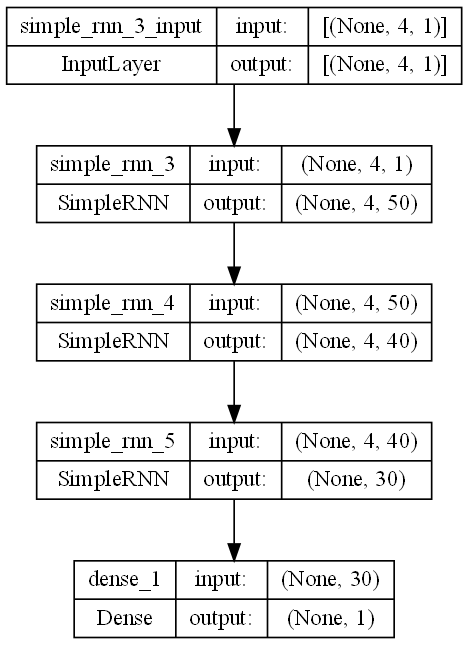

In [31]:
plot_model(
    model,
    to_file="rnn_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=120
)

In [32]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 4, 50)             2600      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 4, 40)             3640      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 30)                2130      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8401 (32.82 KB)
Trainable params: 8401 (32.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Model

The model is trained on historical data and used for making predictions.

model.fit(X_train, y_train, epochs=20, batch_size=64): Trains the model for 20 epochs using batches of 64 samples at a time.
model.predict(X_test): Generates predictions for the test data.
scaler.inverse_transform(predictions): Converts the predicted values back to the original scale since they were normalized earlier using MinMaxScaler.

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train,
    y_train,
    epochs=50,            # can be large, early stopping will handle it
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)
predictions = model.predict(X_test)

Epoch 1/50
16/16 [==============================] - 3s 31ms/step - loss: 0.0412 - val_loss: 0.0095
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 8.2013e-04 - val_loss: 0.0028
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 6.9672e-04 - val_loss: 0.0026
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 6.0385e-04 - val_loss: 0.0022
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 5.8916e-04 - val_loss: 0.0021
Epoch 8/50
16/16 [==============================] - 0s 7ms/step - loss: 5.4770e-04 - val_loss: 0.0024
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss: 5.1609e-04 - val_loss: 0.0021
Epoch 10/50
16/16 [==============================] - 0s 6ms/step - loss: 4.8778e-04 - val_los

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

predictions = model.predict(X_test)


Epoch 1/20
16/16 [==============================] - 3s 29ms/step - loss: 0.0163 - val_loss: 0.0308
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0057
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 6.0857e-04 - val_loss: 0.0015
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 3.5882e-04 - val_loss: 0.0034
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 2.6733e-04 - val_loss: 0.0020
Epoch 6/20
16/16 [==============================] - 0s 6ms/step - loss: 2.3929e-04 - val_loss: 0.0023
Epoch 7/20
16/16 [==============================] - 0s 6ms/step - loss: 2.3144e-04 - val_loss: 0.0018
Epoch 8/20
16/16 [==============================] - 0s 6ms/step - loss: 2.2641e-04 - val_loss: 0.0025
Epoch 9/20
16/16 [==============================] - 0s 7ms/step - loss: 2.1964e-04 - val_loss: 0.0023
Epoch 10/20
16/16 [==============================] - 0s 7ms/step - loss: 2.2426e-04 - va

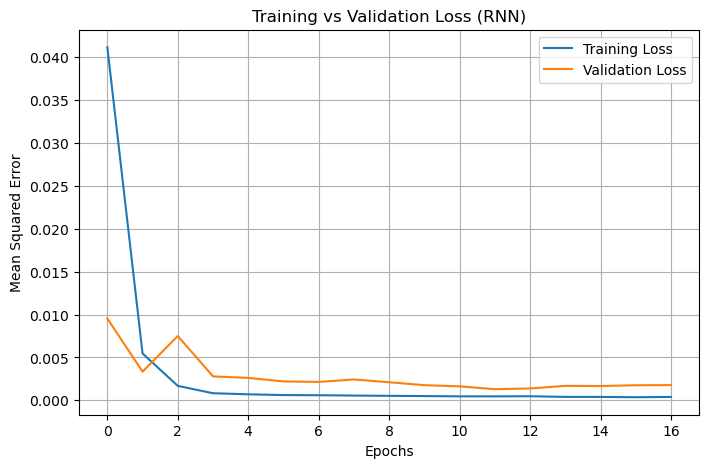

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


## Evaluating the model

The model’s performance is evaluated using standard error metrics. These metrics provide insights into how well the model's predictions align with actual values.

y_test_unscaled: We will use y_test unscaled data to get accurate results.
mean_squared_error(y_test, predictions): Computes the Mean Squared Error (MSE) which measures the average squared difference between actual and predicted values.
np.sqrt(mse): Computes the Root Mean Squared Error (RMSE) which provides error in the same units as the target variable.
mean_absolute_error(y_test, predictions): Computes the Mean Absolute Error (MAE) which measures the average absolute difference between actual and predicted values.

In [35]:
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)

print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")

Unscaled Mean Squared Error (MSE): 53.682703926786424
Unscaled Root Mean Squared Error (RMSE): 7.326848157754221
Unscaled Mean Absolute Error (MAE): 5.817836563900648


## Visualizing the Results

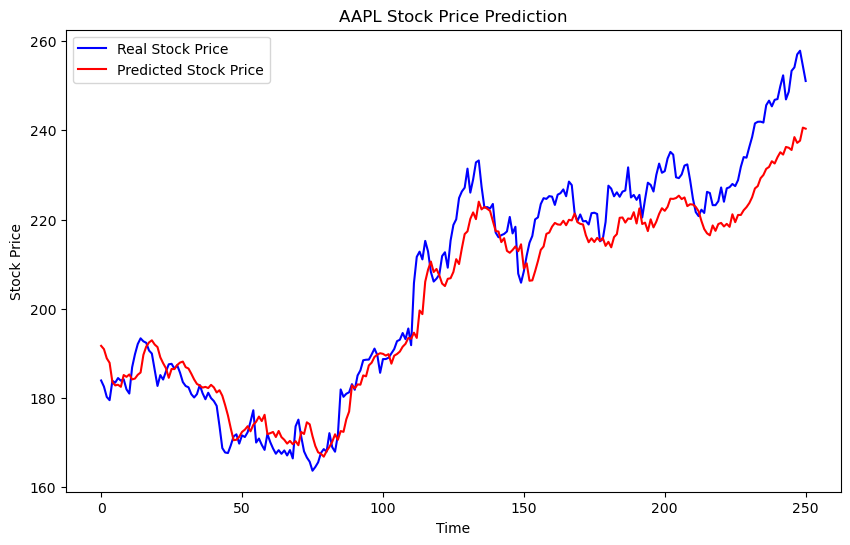

In [36]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Exercise:

1. Change the ticker from AAPL to: MSFT, GOOGL
2. Modify the time_step = 1, 5, 10, 30
3. Questions: How does increasing time_step affect:
4. Model complexity?
5. Training time?
6. Which time_step gives the lowest validation loss?
7. Experiment with number of layers:
8. 1 RNN layer
9. 2 RNN layers
10. 3 RNN layers
11. Questions

Does deeper always mean better?

Where do you observe diminishing returns?

Change number of neurons: [20, 40, 80]
Effect on training loss?

Effect on validation loss?

Plot training vs validation loss.

Questions

Identify overfitting region.

At which epoch should training stop?


## using LSTM

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=40, return_sequences=True))
model_lstm.add(LSTM(units=30, return_sequences=False))
model_lstm.add(Dense(units=1))

In [38]:
from tensorflow.keras.utils import plot_model

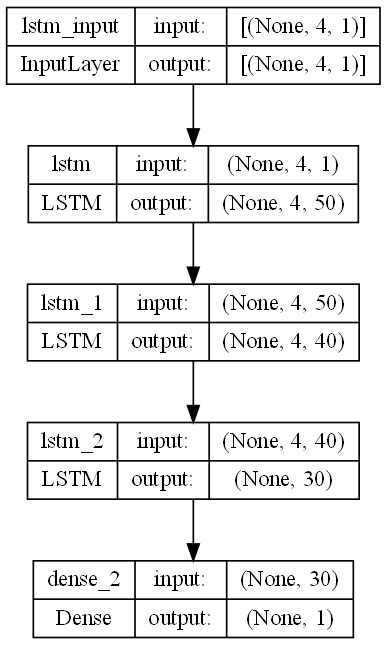

In [39]:
plot_model(
    model_lstm,
    to_file="lstm_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=120
)

In [40]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 4, 40)             14560     
                                                                 
 lstm_2 (LSTM)               (None, 30)                8520      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 33511 (130.90 KB)
Trainable params: 33511 (130.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=64)

predictions = model_lstm.predict(X_test)


Epoch 1/20
16/16 [==============================] - 8s 8ms/step - loss: 0.1372
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0251
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 8/20
16/16 [==============================] - 0s 10ms/step - loss: 7.0257e-04
Epoch 9/20
16/16 [==============================] - 0s 11ms/step - loss: 6.8657e-04
Epoch 10/20
16/16 [==============================] - 0s 12ms/step - loss: 6.4580e-04
Epoch 11/20
16/16 [==============================] - 0s 11ms/step - loss: 6.2183e-04
Epoch 12/20
16/16 [==============================] - 0s 12ms/step - loss: 6.0447e-04
Epoch 13/20
16/16 [====

In [42]:
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)

print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")

Unscaled Mean Squared Error (MSE): 25.528485444517234
Unscaled Root Mean Squared Error (RMSE): 5.052572161238
Unscaled Mean Absolute Error (MAE): 3.8564696292953196


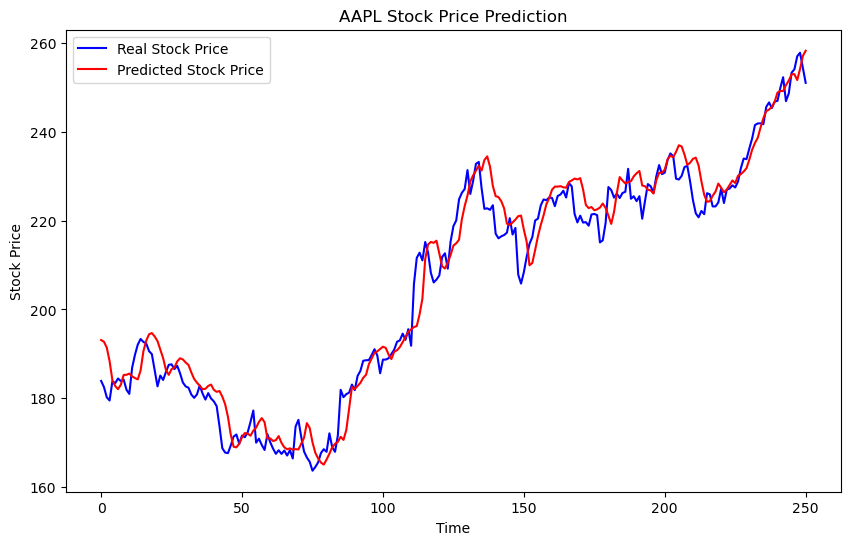

In [43]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU Version

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [45]:
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True,
                  input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=40, return_sequences=True))
model_gru.add(GRU(units=30, return_sequences=False))
model_gru.add(Dense(units=1))


In [46]:
from tensorflow.keras.utils import plot_model

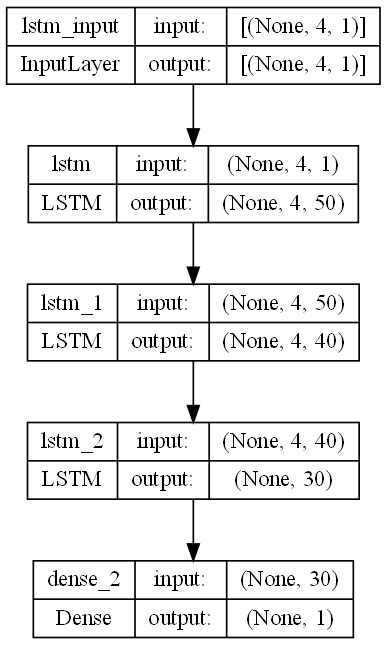

In [47]:
plot_model(
    model_lstm,
    to_file="gru_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=120
)

In [48]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 50)             7950      
                                                                 
 gru_1 (GRU)                 (None, 4, 40)             11040     
                                                                 
 gru_2 (GRU)                 (None, 30)                6480      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 25501 (99.61 KB)
Trainable params: 25501 (99.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=20, batch_size=64)

predictions = model_gru.predict(X_test)
